# Preprocessing generale

Prima di tutto scegliamo di diminuire le modalità di gioco eliminando quelle che contengono pochi record (<10k) in questo modo otteniamo le combinazioni di prima o terza persona X solo, duo, sq4.

Siccome è possibili giocare anche in sq3 andiamo a creare una nuova colonna con il numero effettivo di giocatori nella squadra (cri: alcune sq risultano da 5 persone????)

Andiamo poi a trasformare il tipo di match in 2 colonne: #giocatoriMatch e isFirstPerson


L'idea è quella di esplorare più strade:
- Clustering: Il cluster diretto con i dati potrebbe andare ad individuare solo le modalità del match. 
  - Accorpiamo i dati e facciamo un clustering a livello di gruppi
  - Proviamo a fare un clustering per ogni tipo di gruppo
- Classificazione
  - Classificatore base: ci individua già la divisione per match type? (decision tree, importanza feature)
  - Classificatore con dati accorpati
  - Classificatori diversi per ogni tipo di match

## Divisione del tipo di match

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
#from pyspark.sql import SQLContext


# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
#sqlCtx = SQLContext(sc)
# prevent useless logging messages
sc.setLogLevel("ERROR")

from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()


# load the dataset
data = spark.read.csv("data.csv", header=True, sep=',',inferSchema="true")
data = data.withColumn("distance", data['swimDistance'] + data['walkDistance'] + data['rideDistance'])
data.dtypes

[('Id', 'string'),
 ('groupId', 'string'),
 ('matchId', 'string'),
 ('assists', 'int'),
 ('boosts', 'int'),
 ('damageDealt', 'double'),
 ('DBNOs', 'int'),
 ('headshotKills', 'int'),
 ('heals', 'int'),
 ('killPlace', 'int'),
 ('killPoints', 'int'),
 ('kills', 'int'),
 ('killStreaks', 'int'),
 ('longestKill', 'double'),
 ('matchDuration', 'int'),
 ('matchType', 'string'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('rankPoints', 'int'),
 ('revives', 'int'),
 ('rideDistance', 'double'),
 ('roadKills', 'int'),
 ('swimDistance', 'double'),
 ('teamKills', 'int'),
 ('vehicleDestroys', 'int'),
 ('walkDistance', 'double'),
 ('weaponsAcquired', 'int'),
 ('winPoints', 'int'),
 ('winPlacePerc', 'double'),
 ('distance', 'double')]

In [2]:
from pyspark.sql import SQLContext

sqlCtx = SQLContext(sc)

data.createOrReplaceTempView("pubg")
data.createOrReplaceTempView("pubg_original")

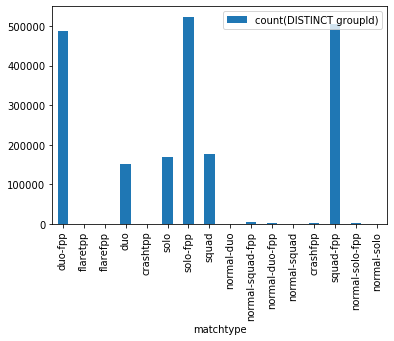

In [3]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) FROM pubg GROUP BY matchtype""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [4]:
toKeep = tmp.rdd.filter(lambda x: x[1] > 10000).map(lambda x: x["matchtype"]).collect()

In [5]:
data = data.filter(data.matchType.isin(toKeep))
data.createOrReplaceTempView("pubg")

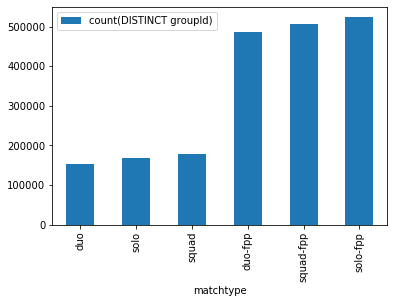

In [6]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [7]:
data = data.withColumn("isFirstPerson", when(col("matchtype").contains("fpp"), True).otherwise(False))

In [8]:
data = data.withColumn("matchtype", when(col("matchtype").contains("duo"), 2)
                           .when(col("matchtype").contains("solo"), 1)
                           .otherwise(4))

data.createOrReplaceTempView("pubg")

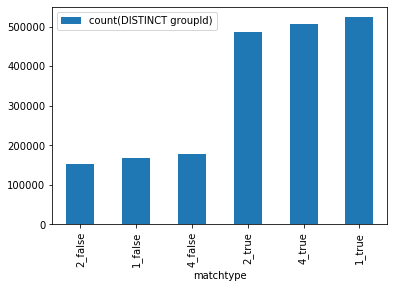

In [9]:
tmp = sqlCtx.sql("""SELECT CONCAT(matchtype, '_', isFirstPerson) as matchtype, count(distinct groupId) 
                        FROM pubg GROUP BY CONCAT(matchtype, '_', isFirstPerson)
                        ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [13]:
import seaborn as sns

In [12]:
sns.kdeplot(data=data.ki, x="kills", hue="math_type")

## Discretizzazione della target variable

In [10]:
#data = data.withColumn("winPlacePerc", when(col("winPlacePerc") == 0 , 2)
#                           .when(col("matchtype").contains("solo"), 1)
#                           .otherwise(4))
#
data.createOrReplaceTempView("pubg")

In [11]:
lista = data.where(data.numGroups == 26).rdd.map(lambda x: x["winPlacePerc"]).collect()

In [12]:
tmp = sqlCtx.sql("""SELECT winPlacePerc FROM pubg where numGroups = 25""")

In [13]:
lista

[0.4444,
 0.7308,
 0.1923,
 0.52,
 0.2222,
 0.64,
 0.72,
 0.4231,
 0.3462,
 0.6538,
 0.8889,
 0.0769,
 0.5385,
 0.9259,
 0.0741,
 0.5385,
 0.08,
 0.1071,
 0.92,
 0.0,
 0.6923,
 0.1852,
 0.4444,
 0.3462,
 0.6154,
 0.44,
 0.8148,
 0.48,
 0.037,
 0.1786,
 0.1852,
 0.16,
 0.12,
 0.8462,
 0.0741,
 0.3704,
 0.0385,
 0.6923,
 0.0,
 0.76,
 0.16,
 0.1154,
 0.7692,
 0.3462,
 0.2963,
 1.0,
 0.9259,
 0.1154,
 0.12,
 0.3077,
 1.0,
 0.8077,
 0.28,
 0.36,
 0.9259,
 0.7143,
 0.7778,
 0.4643,
 0.44,
 0.9231,
 0.3077,
 0.0,
 0.84,
 0.32,
 0.3462,
 0.5385,
 0.2857,
 0.1481,
 0.76,
 0.76,
 0.2069,
 0.3462,
 0.0,
 1.0,
 0.52,
 0.0,
 0.0385,
 0.5769,
 0.32,
 0.12,
 0.48,
 0.76,
 0.3077,
 0.68,
 0.24,
 0.8148,
 0.88,
 0.2593,
 0.7308,
 0.2593,
 0.0769,
 1.0,
 0.8462,
 0.36,
 0.2222,
 1.0,
 0.72,
 0.1154,
 0.92,
 0.6923,
 0.8462,
 0.0769,
 0.0741,
 0.2308,
 0.2692,
 0.0,
 0.7692,
 0.4074,
 0.0,
 0.2692,
 0.04,
 0.44,
 0.3077,
 0.7308,
 0.4231,
 0.3077,
 0.7037,
 0.6667,
 0.7692,
 0.6154,
 0.4231,
 0.32,
 0.52

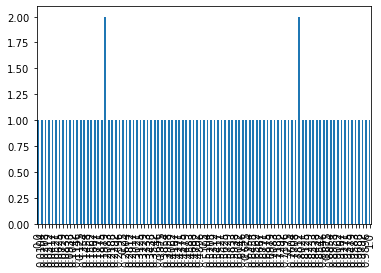

In [14]:
#lista = data.where(data.numGroups == 25).rdd.map(lambda x: x["winPlacePerc"]).collect()
lista = data.where(data.matchId == '6dc8ff871e21e6').rdd.map(lambda x: x["winPlacePerc"]).collect()

tmp = pd.DataFrame()

lista.sort()

tmp["0"] = lista

tmp["0"].value_counts().sort_index().plot(kind="bar")

In [15]:
for i, el in enumerate(lista[0:-1]):
    print(lista[i]-lista[i+1])
    
    

-0.0104
-0.0104
-0.0104
-0.010500000000000002
-0.0104
-0.0104
-0.010400000000000006
-0.010399999999999993
-0.010499999999999995
-0.010400000000000006
-0.010399999999999993
-0.010400000000000006
-0.010399999999999993
-0.01040000000000002
-0.010399999999999993
-0.010499999999999982
-0.01040000000000002
-0.010399999999999993
-0.010399999999999993
0.0
-0.01040000000000002
-0.010499999999999982
-0.010399999999999993
-0.01040000000000002
-0.010399999999999993
-0.01040000000000002
-0.020799999999999985
-0.01050000000000001
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01050000000000001
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.01050000000000001
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01050000000000001
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.010399999999999965
-0.010400000000000076
-0.0103

In [16]:
len(lista)

97

In [17]:
sqlCtx.sql("""SELECT matchtype, matchid, numGroups from pubg""").show(5)

+---------+--------------+---------+
|matchtype|       matchid|numGroups|
+---------+--------------+---------+
|        4|a10357fd1a4a91|       26|
|        4|aeb375fc57110c|       25|
|        2|110163d8bb94ae|       47|
|        4|f1f1f4ef412d7e|       30|
|        1|6dc8ff871e21e6|       95|
+---------+--------------+---------+
only showing top 5 rows



In [18]:
sqlCtx.sql("""SELECT *
                    from pubg 
                    where matchid = '6dc8ff871e21e6' 
                    order by winPlacePerc""").show(100)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+------------------+-------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchtype|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|          distance|isFirstPerson|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------

In [19]:
# Seleziono i duplicati, usabile solo per match da 1 persona
#sqlCtx.sql("""SELECT p1.matchtype, p1.id, p1.groupid, p1.matchid, p1.winPlacePerc, p1.kills
sqlCtx.sql("""SELECT p1.*
                    from pubg p1, pubg p2
                    where p1.matchid = '6dc8ff871e21e6' 
                        and p1.groupid = p2.groupid
                        and p1.id <> p2.id
                    order by winPlacePerc""").show(100)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+--------+-------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchtype|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|distance|isFirstPerson|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+-------------

controllare se si può estrarre dagli 0 i giocatori disconnessi da quelli arrivati ultimi.

Cri: forse conviene prima ricavare i giocatori effettivi nel match (ci dovrebbe essere una variabile simile, che indica il numero di squadre)

Cri - osservazioni sul matchid 6dc8ff871e21e6
Questo match è composto da squadre di una persona.
Se osserviamo il plot (score X #persone) vediamo come ci sono alcuni punteggi assegnati a due persone, il che è possibile solo in caso di pareggio. Nello specifico ci sono 4 persone con lo stesso punteggio (=> 2 non dovrebbero esistere)
La lista di giocatori di tale match risulta essere compsta da 97 elementi, tuttavia, l'attributo numGroups ha valore 95 (che torna con i 2 valori anomali).

I due utenti duplicati hanno come id rispettivamente f921a757de248b e cf806bed1e2faa, tuttavia hanno lo stesso groupid. potrebbe essere causato da una perdita di connessione (rientra in partita dopo un crash)?

Alcuni attributi di un player tra quei due di prima risultano a 0 (distance, weaponsAcquired, damageDealt). 
- Potrebbe essere utile unificare i record? UNICA STRADA POSSIBILE
- Conviene eliminare uno dei due duplicati (ad esempio quello con distance==0)? NON FATTIBILE --> non è sempre vero (vedi groupid 8f7560b8e2a612)

Altre ipotesi:
- numGroups indica il numero di gruppi (distinct groupid) nel match
- maxPlace indica il numero di giocatori (distinct playerid) nel match
- La classifica contiene due giocatori con lo stesso punteggio --> sono quelli crashati e riconnessi che hanno id diverso, ma stesso gruppo. 
- Guardando le distanze tra un winplaceperc e il suo successore otteniamo la maggior parte delle volte un valore costante (.0104...), ma non sempre (alcune volte è il doppio: .0208). Penso quindi che i percentili generati siano nello stesso numero di maxPlace. Per tenere di conto del problema delle disconnessioni dovremmo quindi trasformare la percentuale nella posizione effettiva della classifica e ricalcolare i percentili calcolandoli sull'attributo maxPlace


Date queste osservazioni vedo sempre più necessario il fatto di trattare i dati aggregandoli per gruppi così da poter fare un unico modello e, contemporanemente, risolvere il problema delle riconnessioni (anche perchè nel caso del giocatore singolo sei in grado di capire a che giocatore associare i dati aggregati, nel caso di squadra da più persone chi sarà quello che si è disconnesso/crashato?)

Oss: con somma dei risultati i player risultanti avrebbero alcuni attributi con domanio diverso e dipendente dal tipo di match, forse è meglio fare la media

Suggerimenti per l'aggregazione.
Invariati:
- Id: eliminato
- groupId: nuova chiave
- matchId (dipendende funzionalmente dal gruppo)
- matchDuration
- winPlacePerc
- isFirstPerson
- matchtype
- maxPlace
- numGroups

somma o int(media):
- assists: nel caso di solo possono essere anche != da 0, quindi possiamo fare sei la somma che int(media)
- boosts
- heals
- kills
- headshotKills
- killStreaks
- roadKills
- longestKill
- vehicleDestroys (forse anche top, almeno si savano quei pochi che hanno distrutto un veicolo)
- weaponsAcquired

somma o media:
- damageDealt
- distance
- rideDistance
- swimDistance
- walkDistance

altri
- DBNOs: questo attributo è sempre uguale a 0 nei solo players. Cosa volgiamo fare? aggregare vorrebbe dire avere domini diversi a seconfa della condizione matchtype=solo, mettere tutto a 0/eliminare l'attributo vorrebbe dire perdere dei dati
- revives
- teamKills

migliore?
- killPlace: viene calcolato per ogni giocatore anche in caso di gruppi e riconnessioni.
- rankPoints: sono diversi sempre, anche in caso di gruppi e riconnessioni

strani:
- killPoints: nei 2 match che ho preso i valori sono sempre 0
- winPoints: anche questi sono sempre a 0 nei due match analizzati

In [21]:
sqlCtx.sql("""SELECT 
                        groupId, matchId, matchDuration, winPlacePerc, isFirstPerson, matchtype, maxPlace, numGroups
                        CAST(AVG(assists)as INT)
                    from pubg 
                    order by winPlacePerc""").show(10)

ParseException: 
mismatched input '(' expecting {<EOF>, ';'}(line 3, pos 28)

== SQL ==
SELECT 
                        groupId, matchId, matchDuration, winPlacePerc, isFirstPerson, matchtype, maxPlace, numGroups
                        CAST(AVG(assists)as INT)
----------------------------^^^
                    from pubg 
                    order by winPlacePerc
